In [ ]:
# Paolo Vega
# SQLAlchemy Challenge
# Bootcamp
# Versión 1.0.0 May-03-2020
# Versión 1.0.1 May-03-2020

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [135]:
import datetime as dt
from datetime import timedelta
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Dictionary
# station = {'id':'integer', 'station':'TEXT','name ':'TEXT','latitude':'FLOAT','longitude':'FLOAT','elevation':'FLOAT'}
# measurement = {'id':'integer', 'station':'TEXT','date':'TEXT','prcp':'FLOAT','tobs':'FLOAT'}

# Exploratory Climate Analysis

In [174]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Get latest date in database
last_date = session.query(func.max(Measurement.date).label('last_date')).subquery('t')

# Select fields for precipitaton per day
# Need to update dynamic filter for 1 year *************************
sel = [Measurement.date,
      func.sum(Measurement.prcp)]
precipitation = session.query(*sel).\
                filter(Measurement.date >= '2016-08-23').\
                filter(Measurement.date <= last_date.c.last_date).\
                group_by(Measurement.date).\
                order_by(Measurement.date).all()

# Transform into dataframe
precipitation = pd.DataFrame(precipitation, columns=["day","prcp"])
# update datatype for day
precipitation["day"] = pd.to_datetime(precipitation["day"])
# update index to handle plot easily
precipitation.set_index("day",inplace=True)
# See sample data
display(precipitation.head())

,prcp
day,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


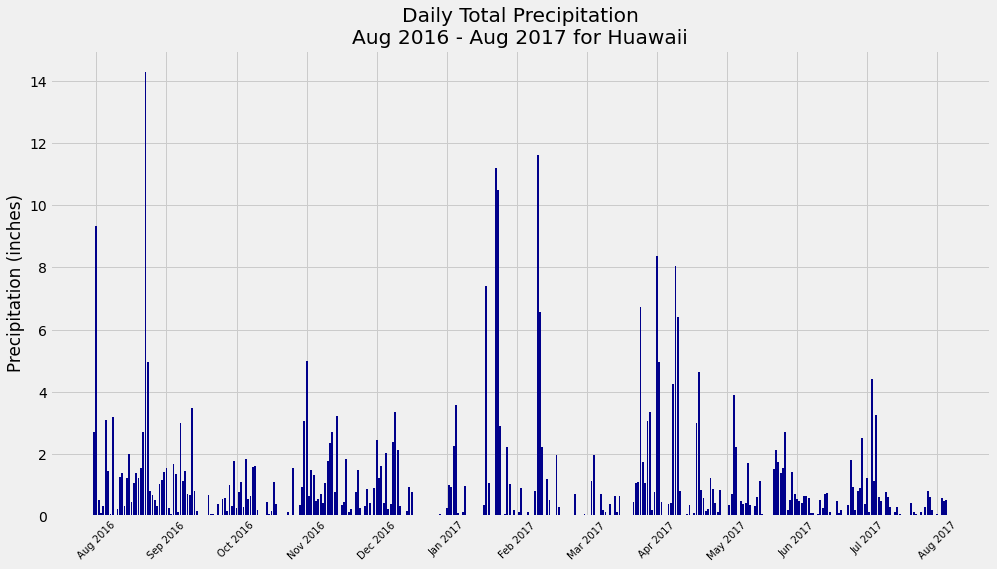

In [175]:

#Plot results
fig, ax = plt.subplots(figsize=(15, 8))

# Add x-axis and y-axis
ax.bar(precipitation.index.values,
       precipitation['prcp'],
       color='darkblue')

# Set title and labels for axes
ax.set(xlabel="",
       ylabel="Precipitation (inches)",
       title="Daily Total Precipitation\nAug 2016 - Aug 2017 for Huawaii")

# Set tick size and rotation
plt.xticks(fontsize=10, rotation=45)
# Set frequency for label each 30 days
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
# Set date format in graph
date_form = DateFormatter("%b %Y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

In [176]:
# Use Pandas to calculate the summary statistics for the precipitation data
display(precipitation.describe())

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [206]:
# Design a query to show how many stations are available in this dataset?
sel_stations = [func.count(Station.station)]
no_stations = session.query(*sel_stations).all()
print(f"Available stations: {no_stations[0][0]}")

# Validation query
# display(engine.execute("SELECT count(distinct s.station) as unique_stations FROM station s").fetchall())

Available stations: 9


In [207]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel_act_stations = [Station.name,
                    func.count(Measurement.date)]
active_stations = session.query(*sel_act_stations).\
                                filter(Station.station == Measurement.station).\
                                group_by(Station.station).\
                                order_by(func.count(Station.station).desc()).all()
active_stations_df = pd.DataFrame(active_stations, columns=["station","rows"])
active_stations_df.set_index("station",inplace=True)
active_stations_df["rows"] = active_stations_df['rows'].map('{:,}'.format)
print("Most active stations in Hawaii - 2010 - 2017")
display(active_stations_df)

# Validation query
#display(engine.execute("SELECT s.station, s.name, count(*) as rows " + 
#                       "FROM station s JOIN measurement m ON m.station=s.station " + 
#                       "GROUP BY s.station, s.name ORDER BY rows desc").fetchall())

Most active stations in Hawaii - 2010 - 2017


,rows
station,
"WAIHEE 837.5, HI US","2,772"
"WAIKIKI 717.2, HI US","2,724"
"KANEOHE 838.1, HI US","2,709"
"WAIMANALO EXPERIMENTAL FARM, HI US","2,669"
"MANOA LYON ARBO 785.2, HI US","2,612"
"KUALOA RANCH HEADQUARTERS 886.9, HI US","2,202"
"HONOLULU OBSERVATORY 702.2, HI US","1,979"
"PEARL CITY, HI US","1,372"
"UPPER WAHIAWA 874.3, HI US",511


In [220]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel_most_act_station = [Station.name,
                        Station.station,
                        func.min(Measurement.tobs).label('low_temp'),
                        func.max(Measurement.tobs).label('max_temp'),
                        func.avg(Measurement.tobs).label('avg_temp')]
most_active_stations = session.query(*sel_most_act_station).\
                                filter(Station.station == Measurement.station).\
                                filter(Station.station == 'USC00519281').\
                                group_by(Station.station).all()
most_active_station_df = pd.DataFrame(most_active_stations, columns=["name","station",
                                                                     "Lowest Temp (°F)",
                                                                     "Maximum Temp (°F)",
                                                                     "Average Temp (°F)"])
most_active_station_df.set_index("station",inplace=True)
#active_stations_df["rows"] = active_stations_df['rows'].map('{:,}'.format)
display(most_active_station_df)

# Validation query
#display(engine.execute("SELECT s.station, s.name, min(m.tobs) as low_temp,  " + 
#                       "max(m.tobs) as Max_temp, avg(m.tobs) as Avg_temp " + 
#                       "FROM station s JOIN measurement m ON m.station=s.station " + 
#                       "WHERE s.station = 'USC00519281'" + 
#                       "GROUP BY s.station, s.name").fetchall())

,name,Lowest Temp (°F),Maximum Temp (°F),Average Temp (°F)
station,,,,
USC00519281,"WAIHEE 837.5, HI US",54.0,85.0,71.663781


In [221]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel_waihee_data = [Measurement.date,
                   Measurement.tobs]
waihee_data = session.query(*sel_waihee_data).\
                filter(Measurement.station == 'USC00519281').\
                filter(Measurement.date >= '2016-08-23').\
                filter(Measurement.date <= last_date.c.last_date).\
                group_by(Measurement.date).\
                order_by(Measurement.date).all()

# Transform into dataframe
waihee_df = pd.DataFrame(waihee_data, columns=["day","temp"])
# update datatype for day
waihee_df["day"] = pd.to_datetime(waihee_df["day"])
# update index to handle plot easily
waihee_df.set_index("day",inplace=True)
# See sample data
display(waihee_df.head())

,temp
day,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


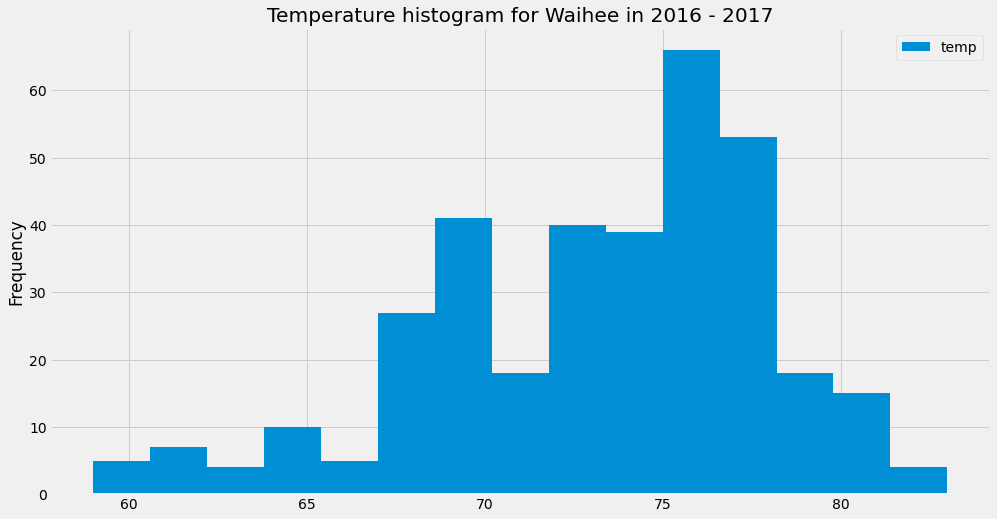

In [226]:
#Plot results
# Validate information ********************
waihee_df.plot(kind="hist",figsize=(15, 8), bins=15, title="Temperature histogram for Waihee in 2016 - 2017")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
